# First run from Alex

Imports...

In [1]:
import pandas
import matplotlib.pyplot as plt
from typing import List, Dict
from collections import defaultdict

Load the data...

In [2]:
timing = pandas.read_csv("./training_timing.csv")
timing

,epoch,batch,id,mem (gb)
0,0,0,before training anything,25.379439
1,0,0,before training adversary (1),25.379439
2,0,0,after training adversary (1),26.608558
3,0,0,after training adversary (2),26.654753
4,0,0,before training main model,26.654831
...,...,...,...,...
2477,8,6,before training adversary (1),82.556834
2478,8,6,after training adversary (1),82.572276
2479,8,6,after training adversary (2),82.588328
2480,8,6,before training main model,82.588328


We need some sort of timing thing. Use `epoch*n_batch + batch_number`.

In [3]:
timing['time'] = timing.epoch*timing.batch.max() + timing.batch
timing

,epoch,batch,id,mem (gb),time
0,0,0,before training anything,25.379439,0
1,0,0,before training adversary (1),25.379439,0
2,0,0,after training adversary (1),26.608558,0
3,0,0,after training adversary (2),26.654753,0
4,0,0,before training main model,26.654831,0
...,...,...,...,...,...
2477,8,6,before training adversary (1),82.556834,406
2478,8,6,after training adversary (1),82.572276,406
2479,8,6,after training adversary (2),82.588328,406
2480,8,6,before training main model,82.588328,406


## Simple memory plots vs time

Look at each as a function of time... Given the total increase in each data set is some number, I'm not sure these different plots are going to do anything but look the same.

First, get a list of all the id's in there.

In [4]:
from typing import Set


def unique_ids(data: pandas.DataFrame) -> Set:
    '''Return a list of the id's in the dataframe.

    Args:
        data (pandas.DataFrame): The data

    Returns:
        Set: Set of the names
    '''
    names = data.id.unique()
    return set(names)

location_names = unique_ids(timing)

Second, a simple function to plot one of the items as a function of "time".

In [5]:
def plot_single_timing(data: pandas.DataFrame, name: str):
    '''Plot the data `name` vs the `time` column as a line plot.

    Args:
        data (pandas.DataFrame): The data to plot
        name (str): The name of the type of data to plot
    '''
    x_values = data[data.id == name].time
    y_values = data[data.id == name]['mem (gb)']

    plt.plot(x_values, y_values, '-o')
    plt.xlabel('Time [epoch*n_batch + batch]')
    plt.ylabel('Memory [GB]')
    plt.title(name)
    plt.show()


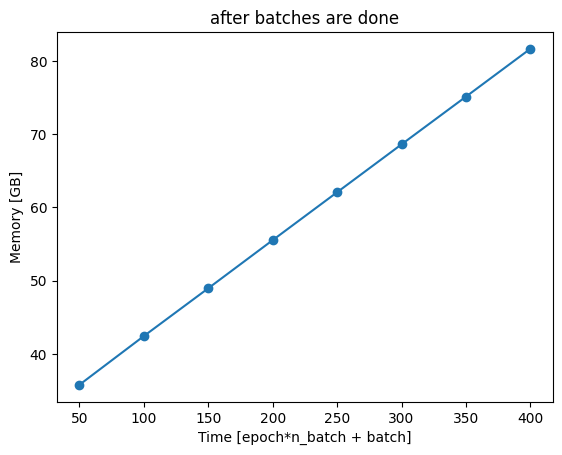

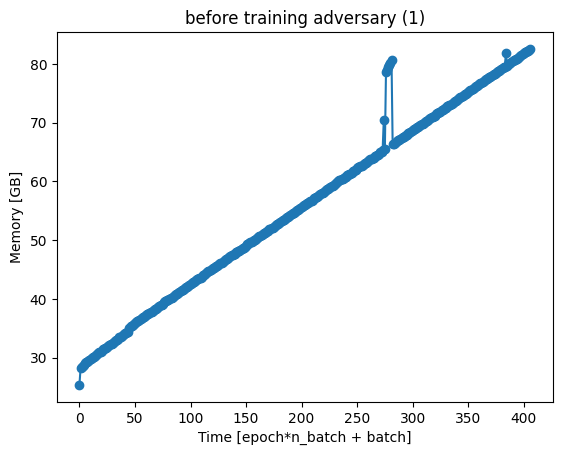

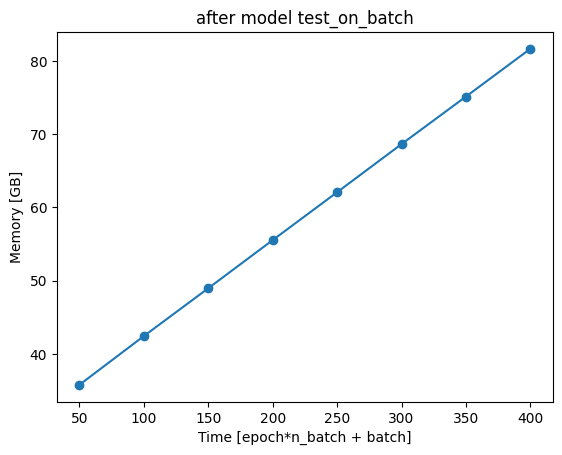

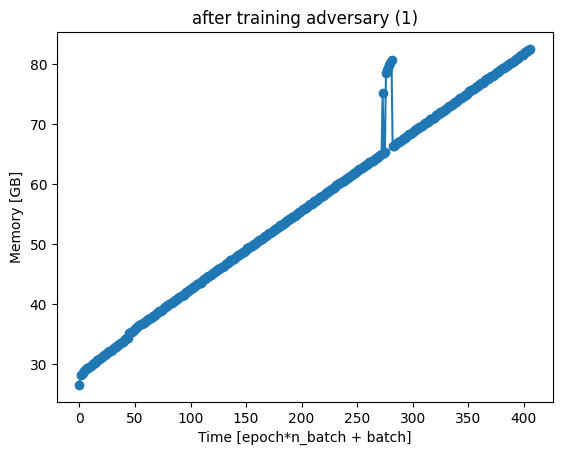

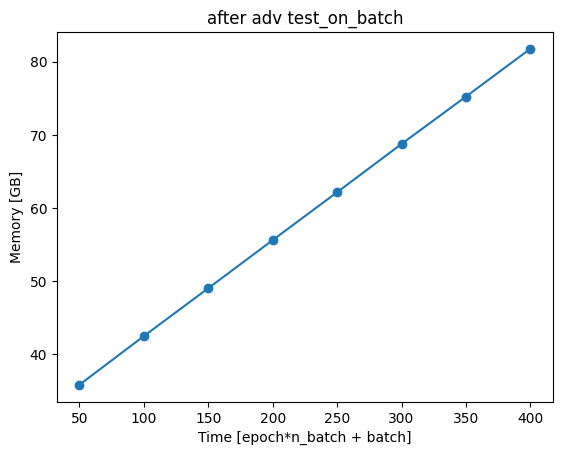

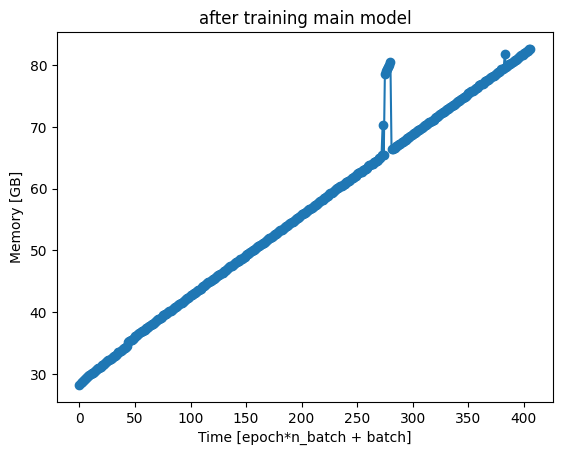

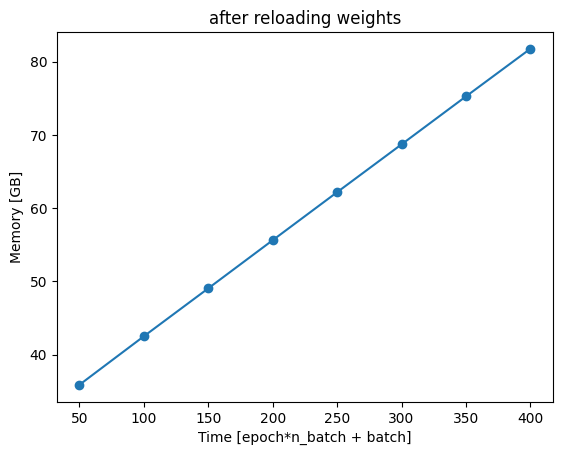

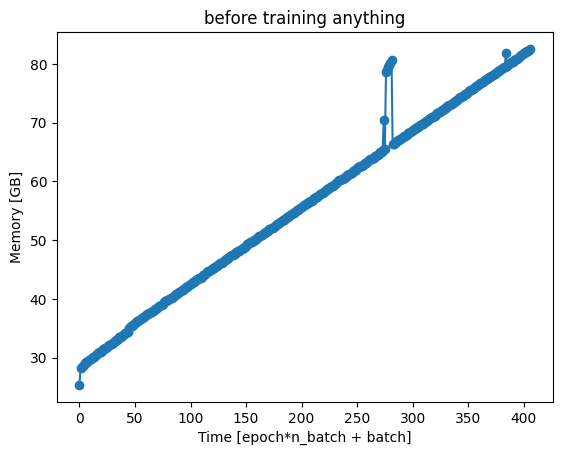

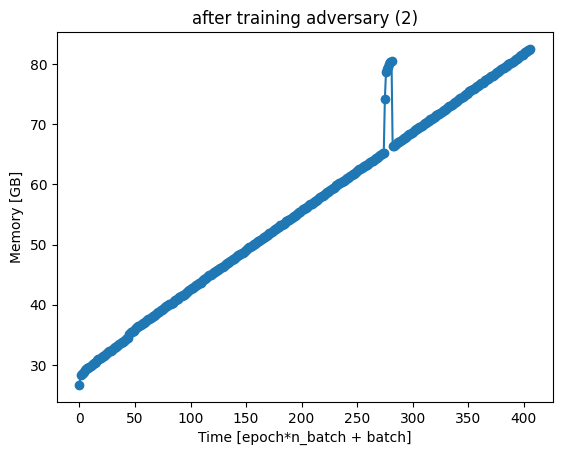

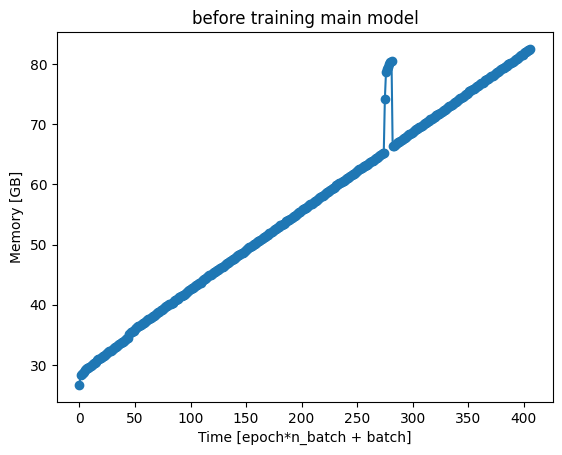

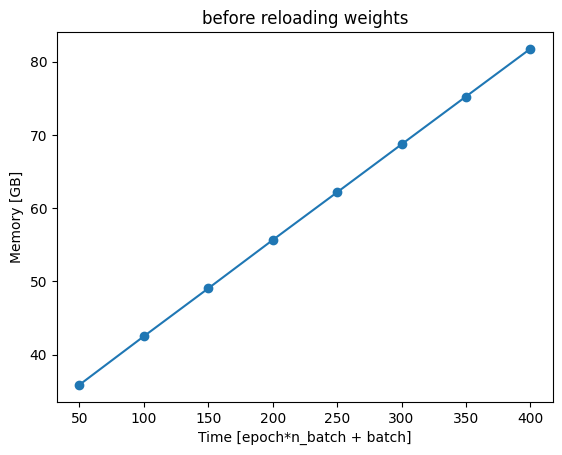

In [6]:
for n in location_names:
    plot_single_timing(timing, n)

## Plotting differences

It is probably much more interesting understanding the deltas between steps. Take adjacent steps, and look at a histogram of those differences.

What is tricky here is that there are some `id`'s in here that have more than one `id` in the line in front of them. For these, we need to be a little careful about how we separate out the data. In short - we will end up making multiple plots depending on the predecessor. This next function will take a DataFrame, and split it out depending on the names. This isn't exactly fast since it runs a loop in python.

In [7]:
def df_split_by_previous(data: pandas.DataFrame, name: str) -> Dict[str, pandas.DataFrame]:
    split_by_names: Dict[str, List[int]] = defaultdict(lambda: [])
    interesting = data[data.id == name].index
    for df_index in interesting:
        if df_index == 0:
            continue
        if data.iloc[df_index].id == name:
            p_df_index = int(df_index - 1)
            p_name = data.iloc[p_df_index].id
            split_by_names[p_name].append(p_df_index)
            split_by_names[p_name].append(df_index)
    
    return {n: timing.iloc[split_by_names[n]] for n in split_by_names.keys()}

Now a plot function that histogram the deltas.

In [8]:
from pyparsing import col


def plot_delta_memory(data: pandas.DataFrame, name_0: str, name_1: str):
    '''Plots the change in memory for each mini-batch between steps `name_0` and `name_1`

    Basically a histogram of `name_1 - name_0`.
        
    Args:
        data (pandas.DataFrame): Timing Data
        name_0 (str): The first step.
        name_1 (str): The second step.
        offset (int): How much to cut off `name_1` at the start (and `name_2` at the end).
                      This is useful when there is a wrap around (and comparing from last mini
                      batch to the next one).
    '''
    time_0 = data[data.id == name_0].time
    y_values_0 = data[data.id == name_0]['mem (gb)'].values
    time_1 = data[data.id == name_1].time
    y_values_1 = data[data.id == name_1]['mem (gb)'].values

    assert len(time_0) == len(time_1), f'"{name_0}" has length {len(time_0)} and "{name_1}" has length {len(time_1)}'

    delta = y_values_1 - y_values_0

    fig, ax = plt.subplots()

    ax.hist(delta, bins=100, range=(-0.15, 0.15))
    ax.set_xlabel('Memory [GB]')
    ax.set_title(f'Memory at {name_1} minus {name_0}')

    ax_in = ax.inset_axes([0.5, 0.5, 0.47, 0.47])
    ax_in.hist(delta, bins=100, color='red')
    ax_in.set_yscale('log')
    ax_in.set_facecolor('None')

    plt.show()

Great - we now have everything we need to go through the complete list and pull out all the relationships showing how memory has changed. Lets loop through all possible items. Inset plot is with no range - so all data is there. The big plot is with a range applied so one can see teh small, but constant, trends.

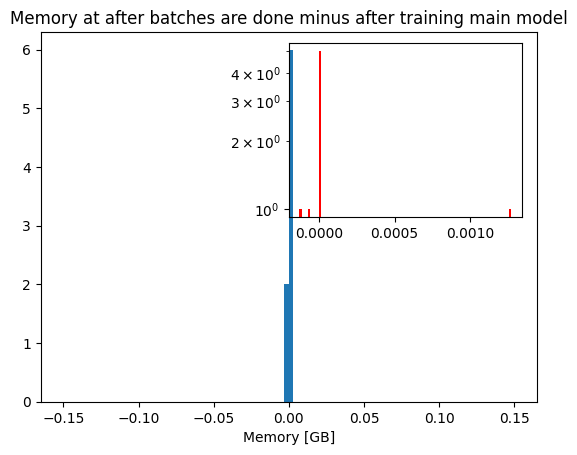

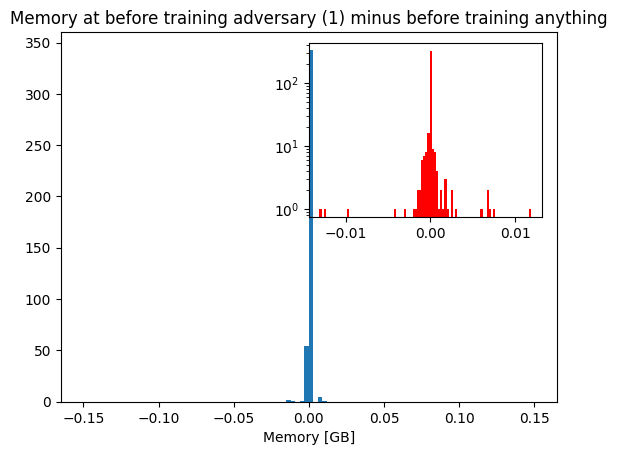

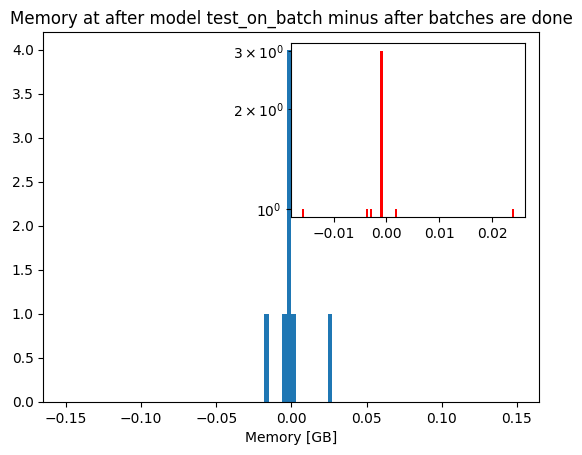

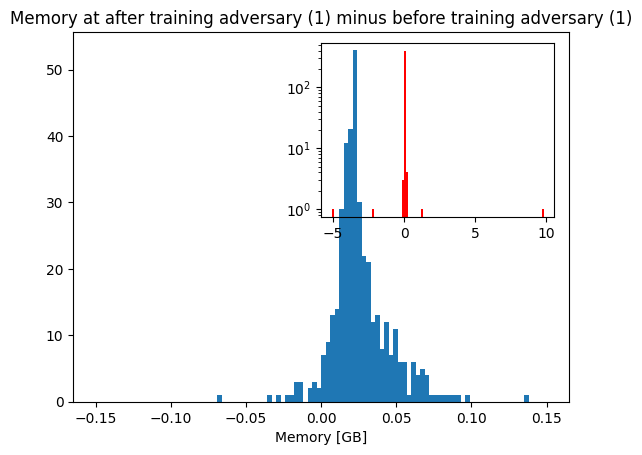

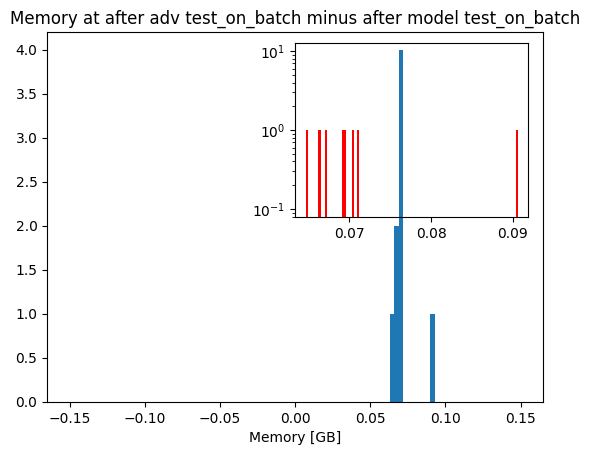

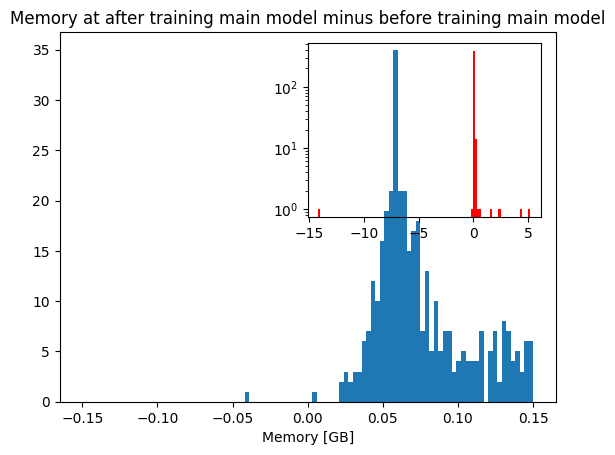

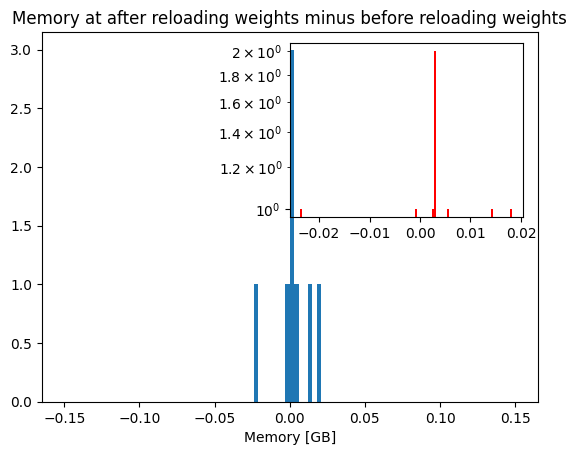

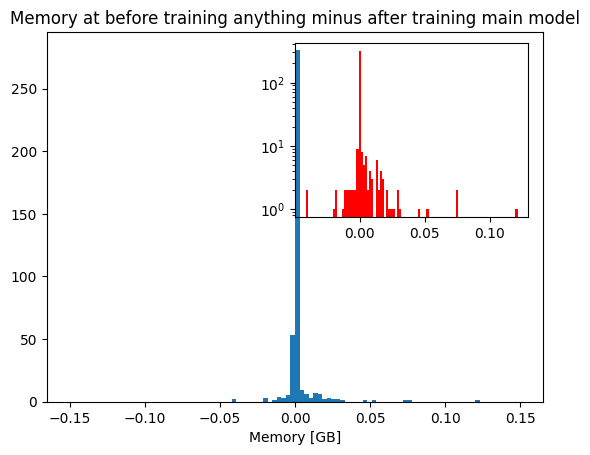

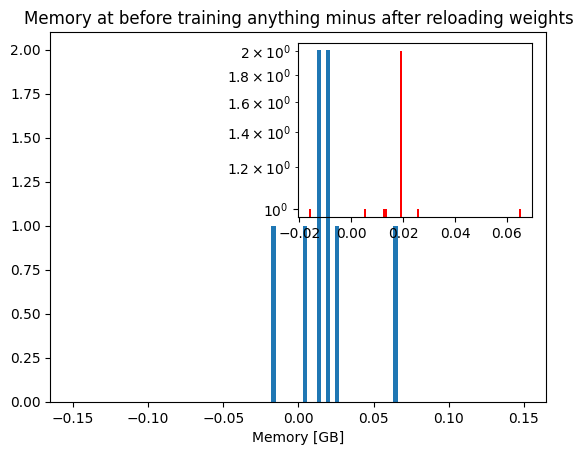

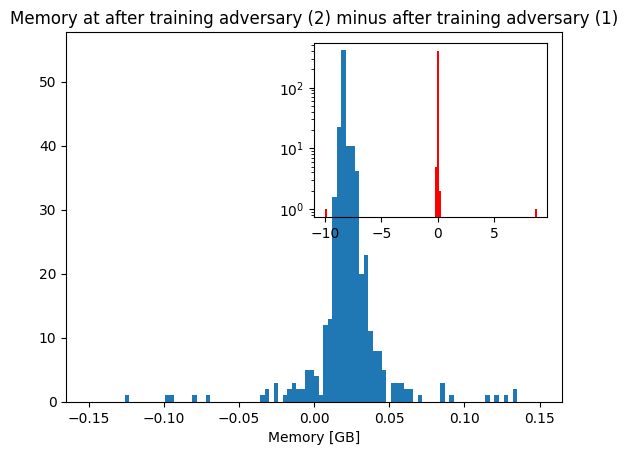

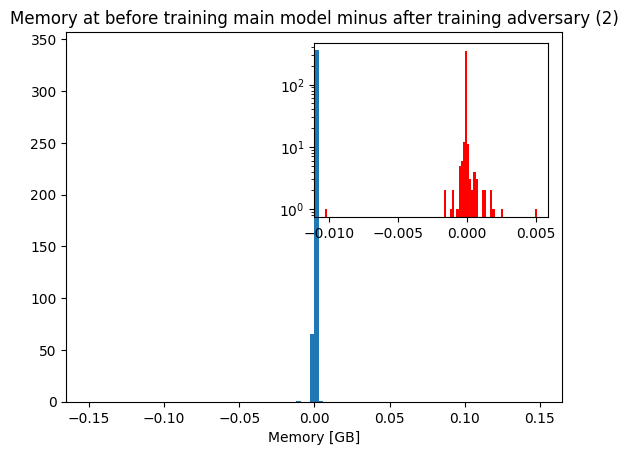

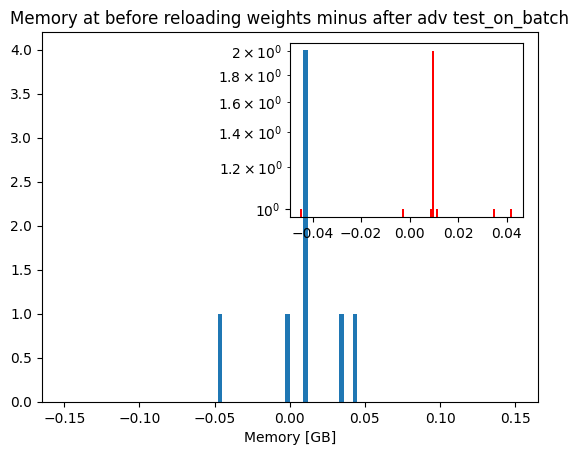

In [9]:
all_ids = unique_ids(timing)
for name in all_ids:
    r = df_split_by_previous(timing, name)
    for k, v in r.items():
        names = unique_ids(v)
        names.remove(name)
        plot_delta_memory(v, list(names)[0], name)

In [10]:
first_name = timing.id[0]
sequence_length = -1
for i in range(1, len(timing)-1):
    if timing.id[i] == first_name:
        sequence_length = i
        break

assert sequence_length > 0
print(f'Measurements points per batch {sequence_length}')

Measurements points per batch 6


Plot a histogram of an arbitrary pairing.

In [11]:
last_plot = timing.id[sequence_length-1]
offset = 1
for index in range(0, sequence_length):
    try:
        plot_delta_memory(timing, last_plot, timing.id[index], offset=offset)
    except Exception as e:
        print(f'Unable to plot ({last_plot}, {timing.id[index]}): {str(e)}')
    offset = 0
    last_plot = timing.id[index]

Unable to plot (after training main model, before training anything): plot_delta_memory() got an unexpected keyword argument 'offset'
Unable to plot (before training anything, before training adversary (1)): plot_delta_memory() got an unexpected keyword argument 'offset'
Unable to plot (before training adversary (1), after training adversary (1)): plot_delta_memory() got an unexpected keyword argument 'offset'
Unable to plot (after training adversary (1), after training adversary (2)): plot_delta_memory() got an unexpected keyword argument 'offset'
Unable to plot (after training adversary (2), before training main model): plot_delta_memory() got an unexpected keyword argument 'offset'
Unable to plot (before training main model, after training main model): plot_delta_memory() got an unexpected keyword argument 'offset'
